In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import interp1d

In [2]:
from kan import *
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
from functions import get_mean_pulse_from_set, momentos, gauss, gauss_fit, move_to_reference, delay_pulse_pair, create_and_delay_pulse_pair
from Models import model_definition

2024-06-20 16:17:19.440400: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-20 16:17:19.464040: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-20 16:17:19.895698: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
V55= np.load('/home/josea/Co60_5cm_5cm.npy')
V28= np.load('/home/josea/Co60_2cm_8cm.npy')
V82= np.load('/home/josea/Co60_8cm_2cm.npy')

In [5]:
#--------------------------------Interpolar pulsos reales---------------------------------
input = V28
EXTRASAMPLING = 8
Nt = np.shape(input)[1]
Nt_new = Nt *  EXTRASAMPLING
time_step = 0.2
new_time_step = time_step / EXTRASAMPLING

tiempo = np.linspace(0, Nt, Nt)
tiempo_new = np.linspace(0,Nt,Nt_new)

interp_func_V28 = interp1d(tiempo, V28, kind = 'cubic', axis=1)
new_V28 = interp_func_V28(tiempo_new)

interp_func_V55 = interp1d(tiempo, V55, kind = 'cubic', axis=1)
new_V55 = interp_func_V55(tiempo_new)

interp_func_V82 = interp1d(tiempo, V82, kind = 'cubic', axis=1)
new_V82 = interp_func_V82(tiempo_new)

REALS = np.concatenate((new_V28, new_V55, new_V82), axis = 0)

print('Number of time points: %.d' % (Nt))
print('Time step: %.2f' % (time_step))
print('New number of time points: %.d' % (Nt_new))
print('New time step: %.4f' % (new_time_step))

Number of time points: 600
Time step: 0.20
New number of time points: 4800
New time step: 0.0250


Text(0, 0.5, 'Voltage [A.U]')

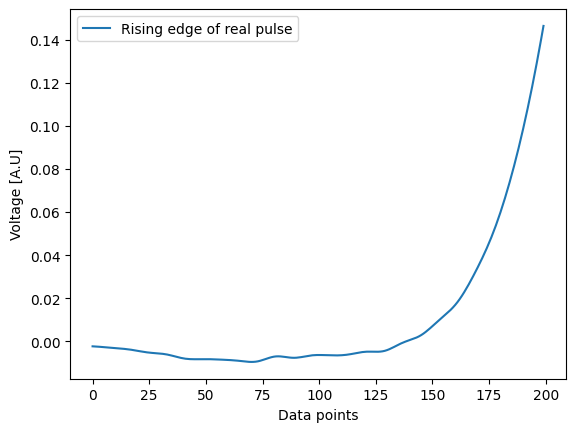

In [6]:
start = 50 * EXTRASAMPLING
stop = 75 * EXTRASAMPLING
plt.plot(new_V55[0,start:stop,0], label = 'Rising edge of real pulse')

plt.legend()
plt.xlabel('Data points')
plt.ylabel('Voltage [A.U]')

In [7]:
trainX_dec0, REF_train_dec0 = create_and_delay_pulse_pair(REALS[:,start:stop,0], new_time_step, delay_steps = 20, NOISE = True)
trainX_dec1, REF_train_dec1 = create_and_delay_pulse_pair(REALS[:,start:stop,1], new_time_step, delay_steps = 20, NOISE = True)

In [8]:
#-------------------------------------------------------------- Calculate moments ---------------------------------------------------
M_Train_dec0 = momentos(trainX_dec0)
M_Train_dec1 = momentos(trainX_dec1)

#-------------------------------------------------------------- Normalize ---------------------------------------------------
min_dec0 = np.min(M_Train_dec0)
max_dec0 = np.max(M_Train_dec0)

min_dec1 = np.min(M_Train_dec1)
max_dec1 = np.max(M_Train_dec1)

M_Train_dec0 = (M_Train_dec0 - min_dec0)/(max_dec0 - min_dec0)
M_Train_dec1 = (M_Train_dec1 - min_dec1)/(max_dec1 - min_dec1)


#-------------------------------------------------------------- Print information ---------------------------------------------------
NM = np.shape(M_Train_dec0)[1]
print(M_Train_dec0.shape, "NM =", NM)
print("Min detector 0:", min_dec0)
print("Max detector 0:", max_dec0)

NM = np.shape(M_Train_dec1)[1]
print(M_Train_dec1.shape, "NM =", NM)
print("Min detector 1:", min_dec1)
print("Max detector 1:", max_dec1)

(736, 12, 2) NM = 12
Min detector 0: -0.610591575928508
Max detector 0: 14.790207842472531
(736, 12, 2) NM = 12
Min detector 1: -0.7887586969387242
Max detector 1: 10.487065530104688


In [9]:
M_V28 = momentos(new_V28[:,start:stop,:])
M_V28[:,:,0] = (M_V28[:,:,0] - min_dec0) / (max_dec0 - min_dec0)
M_V28[:,:,1] = (M_V28[:,:,1] - min_dec1) / (max_dec1 - min_dec1)
print(M_V28.shape)

M_V55 = momentos(new_V55[:,start:stop,:])
M_V55[:,:,0] = (M_V55[:,:,0] - min_dec0) / (max_dec0 - min_dec0)
M_V55[:,:,1] = (M_V55[:,:,1] - min_dec1) / (max_dec1 - min_dec1)
print(M_V55.shape)

M_V82 = momentos(new_V82[:,start:stop,:])
M_V82[:,:,0] = (M_V82[:,:,0] - min_dec0) / (max_dec0 - min_dec0)
M_V82[:,:,1] = (M_V82[:,:,1] - min_dec1) / (max_dec1 - min_dec1)
print(M_V82.shape)

(187, 12, 2)
(268, 12, 2)
(281, 12, 2)


In [10]:
dataset = {}
dataset['train_input'] = torch.from_numpy(M_Train_dec0[:500,:,0])
dataset['train_label'] = torch.from_numpy(np.expand_dims(REF_train_dec0[:500], axis = -1))
dataset['test_input'] = torch.from_numpy(M_Train_dec0[500:,:,0])
dataset['test_label'] = torch.from_numpy(np.expand_dims(REF_train_dec0[500:], axis = -1))

print(dataset['train_input'].shape, dataset['train_label'].shape)

torch.Size([500, 12]) torch.Size([500, 1])


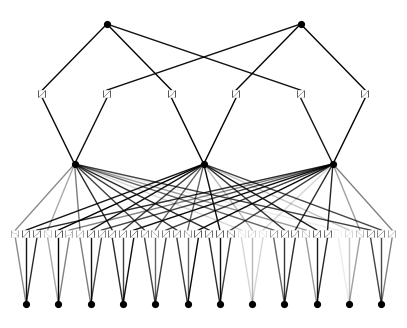

In [11]:
# Create model
model = KAN(width = [12, 3, 2], grid = 5, k = 3, seed = 0)
# plot KAN at initialization
model(dataset['train_input']);
model.plot(beta=100)

In [12]:
# train the model
model.train(dataset, opt = "LBFGS", steps = 20, lamb = 0.01, lamb_entropy = 10.);

train loss: 2.02e-01 | test loss: 2.04e-01 | reg: 2.04e+01 : 100%|██| 20/20 [00:04<00:00,  4.85it/s]


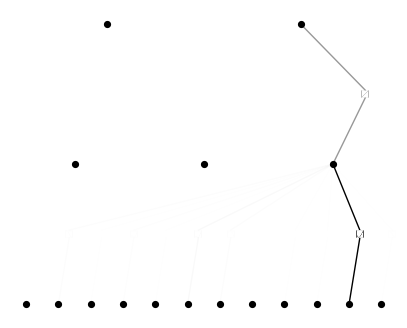

In [13]:
model.prune()
model.plot(mask = True)

In [14]:
mode = "auto" # "manual"

if mode == "manual":
    # manual mode
    model.fix_symbolic(0,0,0,'sin');
    model.fix_symbolic(0,1,0,'x^2');
    model.fix_symbolic(1,0,0,'exp');
elif mode == "auto":
    # automatic mode
    lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
    model.auto_symbolic(lib = lib)

fixing (0,0,0) with sin, r2=0.9929625085413367
fixing (0,0,1) with sin, r2=0.9992258884699274
fixing (0,0,2) with sin, r2=0.40287689470642357
fixing (0,1,0) with x^2, r2=0.9057554164552944
fixing (0,1,1) with tanh, r2=0.9990648112119145
fixing (0,1,2) with sin, r2=0.999646930634849
fixing (0,2,0) with abs, r2=0.18609305976862422
fixing (0,2,1) with abs, r2=0.6770717164237601
fixing (0,2,2) with x^2, r2=0.6507831856694642
fixing (0,3,0) with x^3, r2=0.41224536711968496
fixing (0,3,1) with x^3, r2=0.9905506528880985
fixing (0,3,2) with x^4, r2=0.8775572830113807
fixing (0,4,0) with x^3, r2=0.20922538154262332
fixing (0,4,1) with x^4, r2=0.9850853076528113
fixing (0,4,2) with x^2, r2=0.5056051752090047
fixing (0,5,0) with x^3, r2=0.49091729145478885
fixing (0,5,1) with x^3, r2=0.9847755676428089
fixing (0,5,2) with x^4, r2=0.9314747314220412
fixing (0,6,0) with x^3, r2=0.6391083477876736
fixing (0,6,1) with abs, r2=0.8406743316135846
fixing (0,6,2) with x^2, r2=0.9422327890621939
fixing (

In [15]:
model.symbolic_formula()[0][0]

15787923.8*(-(0.09 - x_6)**4 - 0.05*(0.22 - x_4)**4 - 0.01*Abs(5.57*x_11 - 0.21))**4 + 0.03

# **CUSTOM**

In [18]:
model_dec0 = KAN(width = [12, 3, 1, 1], grid = 5, k = 3, seed = 0)
model_dec1 = KAN(width = [12, 3, 1, 1], grid = 5, k = 3, seed = 0)

In [19]:
# Create DataLoaders
train_dataset_dec0 = torch.utils.data.TensorDataset(torch.from_numpy(M_Train_dec0), torch.from_numpy(np.expand_dims(REF_train_dec0, axis = -1)))
train_loader_dec0 = torch.utils.data.DataLoader(train_dataset_dec0, batch_size = 32, shuffle = True)

train_dataset_dec1 = torch.utils.data.TensorDataset(torch.from_numpy(M_Train_dec1), torch.from_numpy(np.expand_dims(REF_train_dec1, axis = -1)))
train_loader_dec1 = torch.utils.data.DataLoader(train_dataset_dec1, batch_size = 32, shuffle = True)

optimizer_dec0 = torch.optim.AdamW(model_dec0.parameters(), lr = 0.001)
optimizer_dec1 = torch.optim.AdamW(model_dec1.parameters(), lr = 0.001)

In [20]:
def train_one_epoch(model, optimizer, train_loader):
    running_loss = 0.
    last_loss = 0.
    
    for i, data in enumerate(train_loader):
        # Every data instance is an input + label pair
        inputs, labels = data
        
        # Zero your gradients for every batch!
        optimizer.zero_grad()
        
        # Make predictions for this batch
        outputs_0 = model(inputs[:,:,0])
        outputs_1 = model(inputs[:,:,1])

        # Compute the loss and its gradients
        loss = torch.mean((outputs_0 - outputs_1 - labels)**2) + torch.sum(torch.relu(-outputs_0)) + torch.sum(torch.relu(-outputs_1))
        loss.backward()
        
        # Adjust learning weights
        optimizer.step()
        
        # Gather data and report
        running_loss += loss.item()
        
    last_loss = running_loss / int(i) # loss per batch        
    return last_loss

In [21]:
epoch_number = 0
EPOCHS = 75

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))
    
    # Make sure gradient tracking is on, and do a pass over the data
    avg_loss = train_one_epoch(model_dec0, optimizer_dec0, train_loader_dec0)
    
    print('LOSS train {}'.format(avg_loss))
    epoch_number += 1

epoch_number = 0
for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))
    
    # Make sure gradient tracking is on, and do a pass over the data
    avg_loss = train_one_epoch(model_dec1, optimizer_dec1, train_loader_dec1)
    
    print('LOSS train {}'.format(avg_loss))
    epoch_number += 1

EPOCH 1:
LOSS train 0.0545827678081394
EPOCH 2:
LOSS train 0.04551280476840364
EPOCH 3:
LOSS train 0.04070201320588233
EPOCH 4:
LOSS train 0.037145808547283665
EPOCH 5:
LOSS train 0.033817703144475214
EPOCH 6:
LOSS train 0.02853845962463358
EPOCH 7:
LOSS train 0.019907907172419304
EPOCH 8:
LOSS train 0.010912387669609514
EPOCH 9:
LOSS train 0.0066213081433698084
EPOCH 10:
LOSS train 0.004746286551830275
EPOCH 11:
LOSS train 0.0037337238117088976
EPOCH 12:
LOSS train 0.0030276882219747174
EPOCH 13:
LOSS train 0.002581583372405153
EPOCH 14:
LOSS train 0.002276096541225914
EPOCH 15:
LOSS train 0.002049701646664967
EPOCH 16:
LOSS train 0.001696151170309154
EPOCH 17:
LOSS train 0.0014053601695937924
EPOCH 18:
LOSS train 0.001160617516783373
EPOCH 19:
LOSS train 0.0009658919632569579
EPOCH 20:
LOSS train 0.0008311278083840035
EPOCH 21:
LOSS train 0.0007246905460150245
EPOCH 22:
LOSS train 0.0006487467207037602
EPOCH 23:
LOSS train 0.0005966278263829053
EPOCH 24:
LOSS train 0.0005546062421609

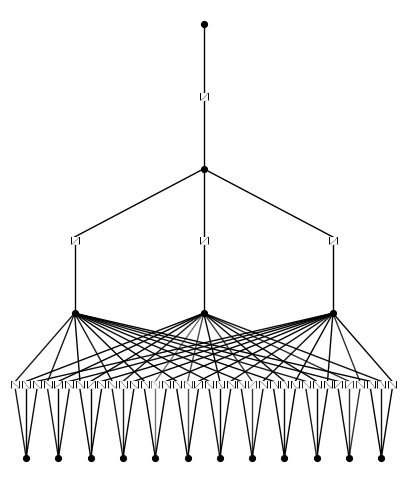

In [22]:
model_dec0(torch.tensor(M_Train_dec0[:,:,0]));
model_dec0.plot(beta=100)

In [23]:
model_dec0.prune()
model_dec1.prune()

KAN(
  (biases): ModuleList(
    (0): Linear(in_features=3, out_features=1, bias=False)
    (1-2): 2 x Linear(in_features=1, out_features=1, bias=False)
  )
  (act_fun): ModuleList(
    (0-2): 3 x KANLayer(
      (base_fun): SiLU()
    )
  )
  (base_fun): SiLU()
  (symbolic_fun): ModuleList(
    (0-2): 3 x Symbolic_KANLayer()
  )
)

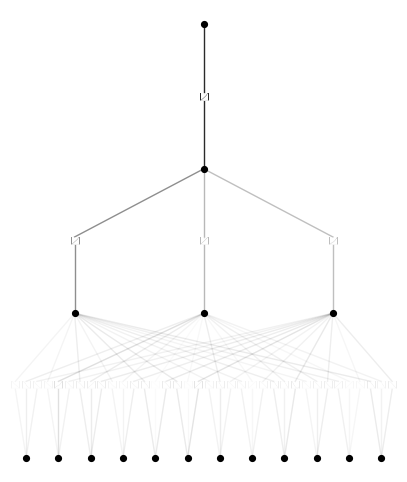

In [24]:
model_dec0.plot(mask = True)
#model_dec1.plot(mask = True)

In [25]:
V28_dec0 = model_dec0(torch.tensor(M_V28[:,:,0]))
V28_dec1 = model_dec1(torch.tensor(M_V28[:,:,1]))

V55_dec0 = model_dec0(torch.tensor(M_V55[:,:,0]))
V55_dec1 = model_dec1(torch.tensor(M_V55[:,:,1]))

V82_dec0 = model_dec0(torch.tensor(M_V82[:,:,0]))
V82_dec1 = model_dec1(torch.tensor(M_V82[:,:,1]))

TOFN_V28 = V28_dec0.detach().numpy() - V28_dec1.detach().numpy()
TOFN_V55 = V55_dec0.detach().numpy() - V55_dec1.detach().numpy()
TOFN_V82 = V82_dec0.detach().numpy() - V82_dec1.detach().numpy()
print(TOFN_V28.shape)

(187, 1)



V82: CENTROID(ns) = 0.207  FWHM(ns) = 0.173  std(ns) = 0.073
V55: CENTROID(ns) = 0.010  FWHM(ns) = 0.155  std(ns) = 0.066
V28: CENTROID(ns) = -0.215  FWHM(ns) = 0.156  std(ns) = 0.066


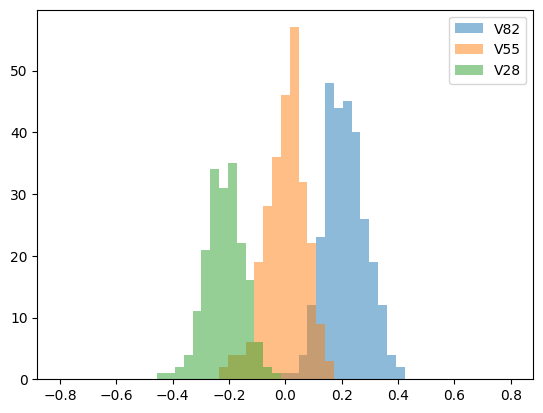

In [26]:
nbins = 51
#------------------------------------------- Histogram and gaussian fit -----------------------------------------------nbins = 51
histogN_V82, binsN, patchesN  = plt.hist(TOFN_V82 - np.mean(TOFN_V55), bins = nbins, range = [-0.8,0.8], alpha = 0.5, label = 'V82');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V82, sigmaN_V82 = gauss_fit(cbinsN, histogN_V82)

histogN_V55, binsN, patchesN  = plt.hist(TOFN_V55 - np.mean(TOFN_V55), bins = nbins, range = [-0.8,0.8], alpha = 0.5, label = 'V55');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V55, sigmaN_V55 = gauss_fit(cbinsN, histogN_V55)

histogN_V28, binsN, patchesN  = plt.hist(TOFN_V28 - np.mean(TOFN_V55), bins = nbins, range = [-0.8,0.8], alpha = 0.5, label = 'V28');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V28, sigmaN_V28 = gauss_fit(cbinsN, histogN_V28)
plt.legend()


FWHMN_V82 = 2.35482 * sigmaN_V82
FWHMN_V55 = 2.35482 * sigmaN_V55
FWHMN_V28 = 2.35482 * sigmaN_V28


print('')
print("V82: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V82, FWHMN_V82, sigmaN_V82))
print("V55: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V55, FWHMN_V55, sigmaN_V55))
print("V28: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V28, FWHMN_V28, sigmaN_V28))

In [27]:
lib = ['exp','log','sqrt','tanh','sin','abs']
model_dec0.auto_symbolic(lib = lib)

fixing (0,0,0) with sqrt, r2=0.998392429785651
fixing (0,0,1) with sin, r2=0.9999825941730734
fixing (0,0,2) with sin, r2=0.9999561533153088
fixing (0,1,0) with sqrt, r2=0.9996213000310203
fixing (0,1,1) with sqrt, r2=0.9751505074958932
fixing (0,1,2) with sin, r2=0.9999823205908426
fixing (0,2,0) with exp, r2=0.9999924493056821
fixing (0,2,1) with exp, r2=0.9997144807542544
fixing (0,2,2) with exp, r2=0.9999933896183117
fixing (0,3,0) with exp, r2=0.9999532539092216
fixing (0,3,1) with sin, r2=0.9999717211161213
fixing (0,3,2) with exp, r2=0.9999599054319988
fixing (0,4,0) with exp, r2=0.9984980790760105
fixing (0,4,1) with exp, r2=0.9999782805323358
fixing (0,4,2) with exp, r2=0.9998619005717942
fixing (0,5,0) with exp, r2=0.9996325554287872
fixing (0,5,1) with exp, r2=0.9999581025427715
fixing (0,5,2) with exp, r2=0.9999469304012331
fixing (0,6,0) with exp, r2=0.9999487482488004
fixing (0,6,1) with sin, r2=0.9998603940742984
fixing (0,6,2) with exp, r2=0.9999994348074797
fixing (0,7

In [28]:
model_dec0.symbolic_formula()[0][0]

4.65 - 2.08*log(3.61*sqrt(0.65*sqrt(x_1 + 0.1) + 0.94*sqrt(x_2 + 0.54) - 0.12*exp(1.8*x_11) + 0.19*exp(1.4*x_3) + 0.01*exp(4.6*x_5) + 0.02*exp(3.2*x_6) + 0.24*exp(1.8*x_8) + 0.31*sin(2.41*x_10 - 7.02) + 0.07*tanh(4.24*x_12 - 1.39) + 0.04*tanh(6.0*x_9 - 1.85) + 1 - 0.54*exp(-1.0*x_7) - 0.54*exp(-1.0*x_4)) - 7.71*exp(-0.06*sqrt(0.83 - x_2) + 0.27*exp(0.4*x_11) - 0.17*exp(1.0*x_5) - 1.32*exp(0.2*x_6) + 0.08*exp(1.0*x_8) - 0.03*sin(4.18*x_1 - 1.59) + 0.03*sin(3.87*x_10 - 4.34) - 0.03*sin(3.71*x_4 - 7.77) + 0.01*sin(6.53*x_7 + 7.21) - 0.e-2*sin(7.13*x_9 + 3.98) - 0.01*tanh(6.4*x_12 - 1.96) - 0.11*exp(-0.2*x_3)) + 0.72*log(0.19*exp(1.6*x_11) + 1.12*exp(1.2*x_12) + 0.29*exp(2.4*x_5) - 6.27*exp(0.2*x_6) + 0.74*exp(2.0*x_8) - 0.93*sin(2.16*x_1 - 9.77) - 0.89*sin(2.72*x_10 - 3.56) + 1.0*sin(2.36*x_2 - 7.19) - 0.08*sin(6.95*x_9 + 2.56) + 19.79 - 10.43*exp(-0.4*x_7) - 0.89*exp(-2.0*x_4) - 1.74*exp(-0.6*x_3)) + 2.81)